# Optimizing sample sizes in A/B testing

In [1]:
from os import path
import pickle

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.stats import multivariate_normal, norm
import seaborn as sns

In [2]:
from matplotlib import rc
rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=16)

In [3]:
figures_path = '/Users/chrissaid/Dropbox/Blog/csaid.github.io/assets/2020_optimizing_sample_sizes'

In [4]:
def plot_heatmap(D, d, Z, show_colorbar=False, show_quad_text=False, show_sigma_c=False, title=''):
    amp = max(np.abs(Z.min()), np.abs(Z.max()))
    pcol = plt.pcolormesh(D, d, Z, cmap=custom_colormap, vmin=-amp, vmax=amp)
    if show_colorbar:
        plt.colorbar()
    if show_quad_text:
        c = np.max(d) / 2
        plt.text(c, c,   'Good\n Ship B, where $ \mu_B > \mu_A $', ha='center', fontsize=10)
        plt.text(-c, c,  'Bad\n Ship B, where $ \mu_A > \mu_B $', ha='center', fontsize=10)
        plt.text(0, -c,  'Neutral\n Keep A', ha='center', fontsize=10)
    if show_sigma_c:
        plt.errorbar([2], [2], show_sigma_c, capsize=2, color='k')
        plt.text(2.2, 2, '$\pm \sigma_c$', va='center')
    plt.xlabel("$\displaystyle \Delta = \mu_B - \mu_A $");
    plt.ylabel("$\displaystyle \delta = \overline{X}_B - \overline{X}_A $");
    plt.title(title)

In [5]:
def ws(c, frac_to_white=0.5):
    """
    Shifts color to white
    """
    return (1-frac_to_white) * c + (frac_to_white) * 1

cdict = {'red':   [
                   [0.0,  ws(237/255.), ws(237/255.)],
                   [0.5,  1.0, 1.0],
                   [1.0,  58/255., 58/255.],
                  ],
         'green': [
                   [0.0,  ws(38/255.), ws(38/255.)],
                   [0.5,  1.0, 1.0],
                   [1.0,  195/255., 195/255.],
                   ],
         'blue':  [
                   [0.0,  ws(133/255.), ws(133/255.)],
                   [0.5,  1.0, 1.0],
                   [1.0,  242/255., 242/255.],
                  ],
        }
custom_colormap = LinearSegmentedColormap('custom_colormap', segmentdata=cdict, N=256)

blue = np.array([58., 195., 242.]) / 255
pink = np.array([237., 38., 133.]) / 255
orange = np.array([245, 128, 50]) / 255
yellow = np.array([241, 211, 33]) / 255
gray = np.array([150, 150, 150]) / 255

### Bivariate normal distribution.
Here we define the bivariate normal distribution over `D`, the true difference in group means, and `d`, the observed difference in group means.

In [6]:
def var_of_group_mean_diff(var_X, n):
    """
    Assuming two groups each with variance var_X
    and sample size n, returns the variance of the difference 
    in means.
    """
    return 2 * var_X / n

def corr_from_var_and_conditional_var(var_x, var_c):
    """
    For a bivariate normal distribution over x and y:
    - var_x: the marginal variance of x
    - var_c: the variance of y, conditional on x
    Returns: the correlation rho between x and y.
    """
    return np.sqrt(1 - var_c/(var_x + var_c))

def get_cov_matrix(var_D, var_X, n):
    """
    var_D: Variance on your Gaussian prior on D, the true difference in means
    var_X: The variance of your observations, X, assumed to be be the
        same in both groups
    n: Sample size of a group.
    """
    var_c = var_of_group_mean_diff(var_X, n)
    var_d = var_c + var_D
    rho = corr_from_var_and_conditional_var(var_D, var_c)
    cov = rho * np.sqrt(var_D) * np.sqrt(var_d)
    return [[var_D, cov], [cov, var_d]]

def get_pdf(cov_matrix, D, d):
    pos = np.empty(D.shape + (2,))
    pos[:, :, 0] = D; 
    pos[:, :, 1] = d
    rv = multivariate_normal([0, 0], cov_matrix)
    pdf = rv.pdf(pos)
    return pdf

In [7]:
def get_lims_and_steps(var_D, var_X, n):
    D_lim = np.sqrt(var_D) * 4
    d_lim = np.sqrt(var_X/n + var_D) * 4
    D_step=D_lim/100
    d_step=d_lim/100
    return D_lim, d_lim, D_step, d_step

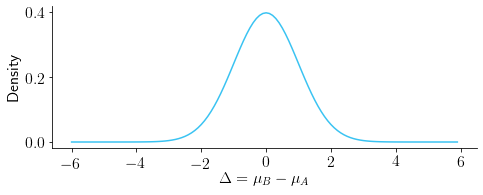

In [319]:
var_D = 5
D = np.arange(-6, 6, .1)
univariate_pdf = norm.pdf(D)
plt.figure(figsize=[7,3])
plt.plot(D, univariate_pdf, color=blue)
plt.xlabel("$\displaystyle \Delta = \mu_B - \mu_A $");
plt.ylabel('Density');
plt.tight_layout()
sns.despine()
plt.savefig(path.join(figures_path, 'univariate_normal.png'), dpi=150)


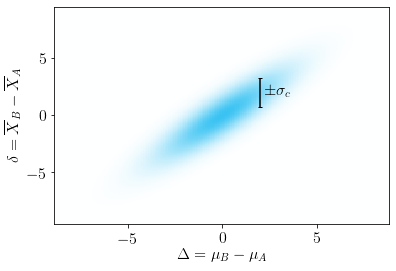

In [9]:
var_X = 400
n = 500
D_lim, d_lim, D_step, d_step = get_lims_and_steps(var_D, var_X, n)
D, d = np.meshgrid(np.arange(-D_lim, D_lim, D_step), np.arange(-d_lim, d_lim, d_step))
cov_matrix = get_cov_matrix(var_D=var_D, var_X=var_X, n=n)
pdf = get_pdf(cov_matrix, D, d)

var_c = var_of_group_mean_diff(var_X, n)
plot_heatmap(D, d, pdf, show_colorbar=False, show_quad_text=False, show_sigma_c=np.sqrt(var_c))
plt.savefig(path.join(figures_path, 'bivariate_normal.png'), dpi=150)

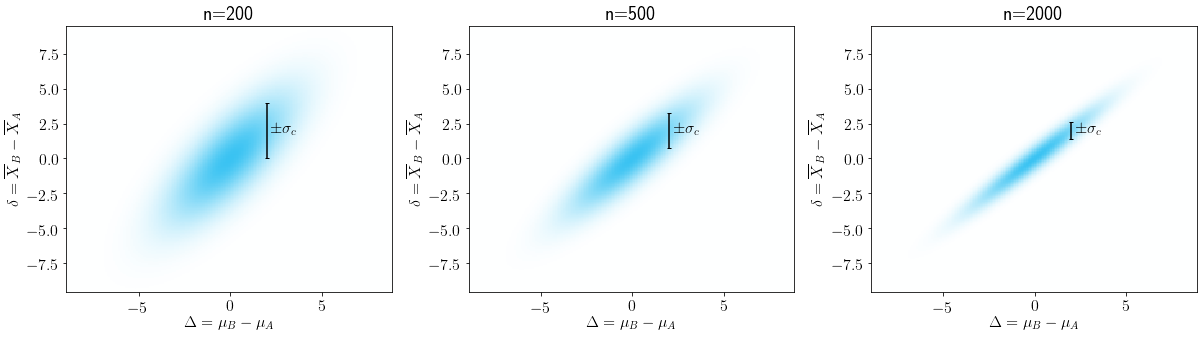

In [10]:
def plot_multiple_pdfs():
    fig, axes = plt.subplots(1, 3, figsize=[17, 5])
    for i, n in enumerate([200, 500, 2000]):
        var_c = var_of_group_mean_diff(var_X, n)
        cov_matrix_for_n = get_cov_matrix(var_D=var_D, var_X=var_X, n=n)
        pdf_for_n = get_pdf(cov_matrix_for_n, D, d)
        plt.sca(axes[i])
        plot_heatmap(D, d, pdf_for_n, show_colorbar=False, show_quad_text=False, show_sigma_c=np.sqrt(var_c), title=f'n={n}')
plot_multiple_pdfs()
plt.tight_layout()
plt.savefig(path.join(figures_path, 'three_bivariate_normals.png'), dpi=150)

## Lift Outcomes

In [11]:
def get_lift_matrix(D, d):
    return np.where(d>0, D, 0)

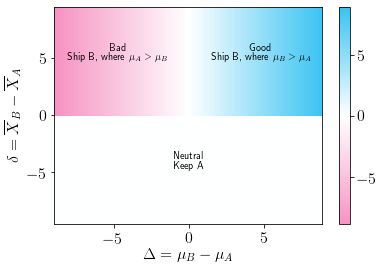

In [12]:
lift_matrix = get_lift_matrix(D, d)
plot_heatmap(D, d, lift_matrix, show_colorbar=True, show_quad_text=True)
plt.savefig(path.join(figures_path, 'lift_matrix.png'), dpi=150)

In [13]:
def get_product(lift_matrix, pdf):
    return lift_matrix * pdf

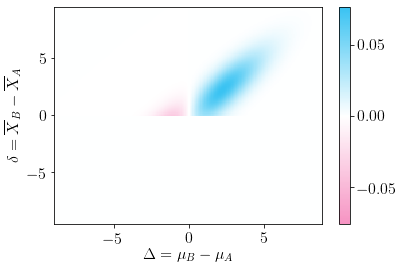

In [14]:
product = get_product(lift_matrix, pdf)
plot_heatmap(D, d, product, show_colorbar=True, show_quad_text=False)
plt.savefig(path.join(figures_path, 'product_matrix.png'), dpi=150)

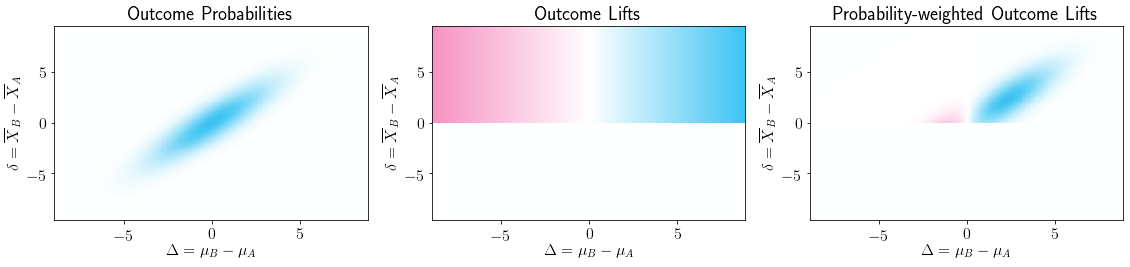

In [15]:
fig, axes = plt.subplots(1, 3, figsize=[16, 4])
plt.sca(axes[0]); plot_heatmap(D, d, pdf, title='Outcome Probabilities')
plt.sca(axes[1]); plot_heatmap(D, d, lift_matrix, title='Outcome Lifts')
plt.sca(axes[2]); plot_heatmap(D, d, product, title='Probability-weighted Outcome Lifts')
plt.tight_layout()
plt.savefig(path.join(figures_path, 'product_stages.png'), dpi=150)

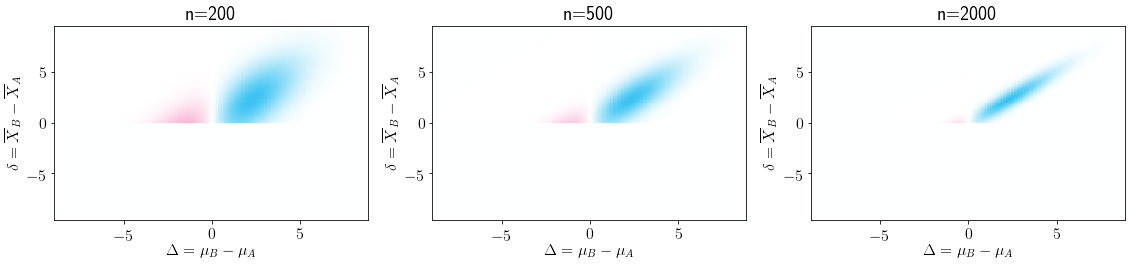

In [16]:
def plot_multiple_prob_weighted_outcome_lift_matrices():
    fig, axes = plt.subplots(1, 3, figsize=[16, 4])
    for i, n in enumerate([200, 500, 2000]):
        cov_matrix_for_n = get_cov_matrix(var_D=var_D, var_X=400, n=n)
        pdf_for_n = get_pdf(cov_matrix_for_n, D, d)
        product_for_n = get_product(lift_matrix, pdf_for_n)
        plt.sca(axes[i])
        plot_heatmap(D, d, product_for_n, title=f'n={n}')
plot_multiple_prob_weighted_outcome_lift_matrices()
plt.tight_layout()
plt.savefig(path.join(figures_path, 'three_products.png'), dpi=150)

# Estimating expected per-user lift, $\hat{L}$
Note that these are your estimates before even starting the experiment. Once you have actually run the experiment and measured $ \delta $, your estimates will change.

In [17]:
def get_pdf_and_lift_matrix(var_D, var_X, n):
    D_lim, d_lim, D_step, d_step = get_lims_and_steps(var_D, var_X, n)
    D, d = np.meshgrid(np.arange(-D_lim, D_lim, D_step), np.arange(-d_lim, d_lim, d_step))

    cov_matrix = get_cov_matrix(var_D=var_D, var_X=var_X, n=n)
    pdf = get_pdf(cov_matrix, D, d)
    lift_matrix = get_lift_matrix(D, d)
    return pdf, lift_matrix, D_step, d_step

### The numeric solution

In [18]:
def get_lift_numerically(var_D, var_X, n):
    """
    Integrate the probability-weighted outcome lift_matrices the easy way.
    """
    
    pdf, lift_matrix, D_step, d_step = get_pdf_and_lift_matrix(var_D, var_X, n)

    auc = pdf.sum() * D_step * d_step
    
    if auc < 0.99 or auc > 1.01:
        raise ValueError('Area under probability distribution not equal to 1. Consider expanding your grid')
    return (lift_matrix * pdf).sum() * D_step * d_step

### The closed-form solution

In [19]:
def get_lift_via_closed_form(var_D, var_X, n):
    var_c = var_of_group_mean_diff(var_X, n)
    return var_D / np.sqrt(2*np.pi*(var_D + var_c))

### The simulation solution

In [20]:
def get_lift_via_simulated_experiments_continuous(var_D, var_X, n, niter=20000):
    lifts = np.empty(niter)
    for i in range(niter):
        D_i = np.sqrt(var_D) * np.random.randn()
        xA = np.sqrt(var_X) * np.random.randn(n) - D_i/2
        xB = np.sqrt(var_X) * np.random.randn(n) + D_i/2
        d_i = xB.mean() - xA.mean()
        if d_i > 0: 
            lift_i = D_i
        else:
            lift_i = 0
        lifts[i] = lift_i
    return (np.array(lifts)).mean()

In [21]:
def get_lift_via_simulated_experiments_binary(var_D, p, n, niter=40000):
    lifts = np.empty(niter)
    for i in range(niter):
        D_i = np.sqrt(var_D) * np.random.randn()

        # Conversion rates
        xA = np.random.binomial(n, p - D_i/2) / n
        xB = np.random.binomial(n, p + D_i/2) / n        
        
        d_i = xB - xA
        if d_i > 0: 
            lift_i = D_i
        else:
            lift_i = 0
        lifts[i] = lift_i
    return (np.array(lifts)).mean()

In [22]:
def get_max_expected_lift(var_D):
    return np.sqrt(var_D) /  np.sqrt(2 * np.pi)

### Tests

In [23]:
def assert_method_close_to_avg(avg_of_methods, lift_from_method):
    assert lift_from_method / avg_of_methods > 0.97 and lift_from_method / avg_of_methods < 1.03

def run_through_asserts(numeric_lift, closed_form_lift, simulated_lift):
    avg_of_methods = np.average([numeric_lift, closed_form_lift, simulated_lift])

    assert_method_close_to_avg(avg_of_methods, numeric_lift)
    assert_method_close_to_avg(avg_of_methods, closed_form_lift)
    assert_method_close_to_avg(avg_of_methods, simulated_lift)
    
def assert_methods_close(var_D, var_X, n):
    
    numeric_lift = get_lift_numerically(var_D, var_X, n)
    closed_form_lift = get_lift_via_closed_form(var_D, var_X, n)
    simulated_lift = get_lift_via_simulated_experiments_continuous(var_D, var_X, n)
        
    run_through_asserts(numeric_lift, closed_form_lift, simulated_lift)
    
def assert_methods_close_conversion(var_D, p, n):
    var_X = p * (1 - p)
            
    numeric_lift = get_lift_numerically(var_D, var_X, n)
    closed_form_lift = get_lift_via_closed_form(var_D, var_X, n)
    simulated_lift = get_lift_via_simulated_experiments_binary(var_D, p, n)
    
    run_through_asserts(numeric_lift, closed_form_lift, simulated_lift)

In [24]:
### Test continuous cases
assert_methods_close(var_D=5, var_X=400, n=200)
assert_methods_close(var_D=15, var_X=400, n=200)
assert_methods_close(var_D=5, var_X=400, n=1000)
assert_methods_close(var_D=5, var_X=100, n=200)
assert_methods_close(var_D=5, var_X=800, n=200)

In [25]:
### Test binary outcome cases
assert_methods_close_conversion(var_D=(.01)**2, p=0.2, n=1000)
assert_methods_close_conversion(var_D=(.02)**2, p=0.2, n=1000)
assert_methods_close_conversion(var_D=(.01)**2, p=0.2, n=1000)
assert_methods_close_conversion(var_D=(.02)**2, p=0.1, n=5000)
assert_methods_close_conversion(var_D=(.02)**2, p=0.5, n=1000)

## Demonstration of Closed Form Lift vs Simulated Lift

In [26]:
def plot_lift_by_n(ns, lifts_via_closed_form, lifts_via_simulation):
    plt.figure(figsize=[7, 4])
    plt.plot(ns, lifts_via_closed_form, label='Closed Form', color=gray)
    plt.plot(ns, lifts_via_simulation, label='Simulation', color=blue)
    plt.xlabel('$n$')
    plt.ylabel('$\hat{L}$')
    plt.legend()
    sns.despine()
    plt.tight_layout()

### Continuous

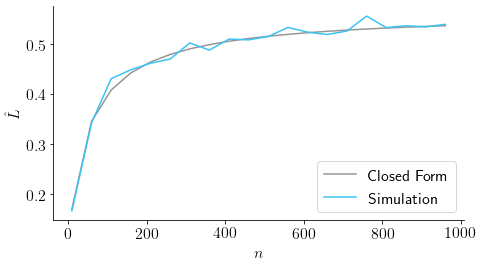

In [27]:
var_D = 2, 
var_X = 100
ns = np.arange(10, 1000, 50)

lifts_via_closed_form = [get_lift_via_closed_form(
    var_D, var_X, n) for n in ns]

lifts_via_simulation = [get_lift_via_simulated_experiments_continuous(
    var_D, var_X, n, niter=5000) for n in ns]

plot_lift_by_n(ns, lifts_via_closed_form, lifts_via_simulation)
plt.savefig(path.join(figures_path, 'lift_by_n_continuous.png'), dpi=150)


### Binary

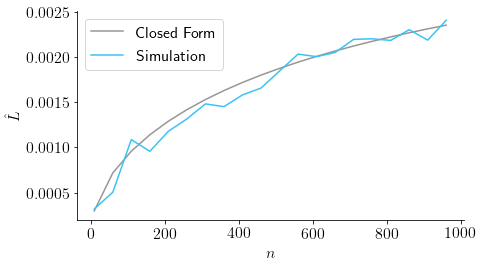

In [28]:
var_D = (0.01)**2, 
p = 0.1
ns = np.arange(10, 1000, 50)

lifts_via_closed_form = [get_lift_via_closed_form(
    var_D, var_X=p*(1-p), n=n) for n in ns]

lifts_via_simulation = [get_lift_via_simulated_experiments_binary(
    var_D, p, n, niter=5000) for n in ns]

plot_lift_by_n(ns, lifts_via_closed_form, lifts_via_simulation)
plt.savefig(path.join(figures_path, 'lift_by_n_binary.png'), dpi=150)


# Aggregate time-discounted lift

### Analytic functions

In [301]:
def discount_function(t, M, L, r):
    return L * M * np.exp(-r*t)

def integral_of_discount_function(t, M, L, r):
    return -L * M * np.exp(-r*t)/r

def value_from_t1_to_t2(t1, t2, M, L, r):
    return integral_of_discount_function(t2, M, L, r) - integral_of_discount_function(t1, M, L, r)

def get_agg_lift_via_closed_form(var_D, var_X, m, tau, r, M):
    """
    Function for estimating L_a.
    
    var_D: Variance on your Gaussian prior on D, the true difference in means
    var_X: The variance of your observations, X, assumed to be be the
        same in both groups
    m: Number of bucketed sessions per day and per bucket.
    tau: Duration of experiment, in days. Assumes you ship the winning bucket immediately after experiment ends.
    r: daily (not annual) discount rate
    M: The total number of sessions per day on your product
    niter: Number of iterations
    """
    
    L = get_lift_via_closed_form(var_D=var_D, var_X=var_X, n=m*tau)
    return value_from_t1_to_t2(t1=tau, t2=np.inf, M=M, L=L, r=r)

def get_neg_agg_lift_via_closed_form_tau_first(tau, var_D, var_X, m, r):
    return -get_agg_lift_via_closed_form(var_D=var_D, var_X=var_X, m=m, tau=tau, r=r, M=1)

def find_optimal_tau(var_D, var_X, m, r):
    """
    var_D: Variance on your Gaussian prior on D, the true difference in means
    var_X: The variance of your observations, X, assumed to be be the
        same in both groups
    m: Number of bucketed sessions per day and per bucket.
    r: daily (not annual) discount rate

    Returns tau, the optimal duration of the experiment, in days
    """
    res = minimize(get_neg_agg_lift_via_closed_form_tau_first, x0=(40), 
                   args=(var_D, var_X, m, r), bounds=((1, None),))
    return res.x[0]


### Simulation functions

In [30]:
def get_last_date(t1, r, frac=0.99):
    """
    returns a date t2 such that the area from t1 to t2 is 0.99 of
    the area from t1 to infinity.
    
    r is the discount rate in days
    """
    
    return -int((np.log((1-frac) * np.exp(-r*t1)/r) + np.log(r)) / r)


def run_experiment(D_i, var_X, n):
    # big d or D means B is better
    xA = np.sqrt(var_X) * np.random.randn(n) - D_i/2
    xB = np.sqrt(var_X) * np.random.randn(n) + D_i/2
    d_i = xB.mean() - xA.mean()

    return d_i
    
def accrue_benefit(D_i, d_i, M, tau, r, frac=0.98):
    
    
    
    if d_i < 0:
        return 0 # Keep running A

    else:
        lift = D_i # Ship B
        
        tau_2 = get_last_date(tau, r, frac=frac) # only simulate the post-experiment period as far out as you need to
        days = np.repeat(np.arange(tau, tau_2), M)
        total_M = (tau_2 - tau) * M

        df = pd.DataFrame({
            'day': days,
            'x': np.sqrt(var_X) * np.random.randn(total_M) + lift,
        })

        df = df.assign(
            x_discounted = discount_function(t=df['day'], 
                                             M=1, # because just one session per row
                                             L=df['x'], 
                                             r=r)
        )

        return df['x_discounted'].sum() / frac
    

def run_experiment_and_accrue_benefit(var_D, var_X, m, tau, r, M):
    # The true difference in this universe
    D_i = np.sqrt(var_D) * np.random.randn()
    d_i = run_experiment(D_i, var_X, n=m*tau)
    benefit = accrue_benefit(D_i, d_i, M, tau, r)

    return benefit

def get_agg_lift_via_simulations(var_D, var_X, m, tau, r, M, niter):
    """
    Function for estimating L_a.
    
    var_D: Variance on your Gaussian prior on D, the true difference in means
    var_X: The variance of your observations, X, assumed to be be the
        same in both groups
    m: Number of bucketed sessions per day and per bucket.
    tau: Duration of experiment, in days. Assumes you ship the winning bucket immediately after experiment ends.
    r is daily (not annual) discount rate
    M: The total number of sessions per day on your product
    niter: Number of iterations
    """                             
    benefits = np.empty(niter)
    for i in range(niter):
        benefits[i] = run_experiment_and_accrue_benefit(var_D, var_X, m, tau, r, M)
               
    return benefits.mean()

### Examples

In [31]:
get_agg_lift_via_closed_form(var_D=1, var_X=100, m=100, tau=20, r=1/365, M=200)

26286.915279571378

In [32]:
get_agg_lift_via_simulations(var_D=1, var_X=100, m=100, tau=20, r=1/365, M=200, niter=1000)

26967.17691948427

In [36]:
find_optimal_tau(var_D=1, var_X=100, m=100, r=1/365)

18

In [37]:
p = 0.1
get_agg_lift_via_closed_form(var_D=0.01**2, var_X=p*(1-p), m=100, tau=25, r=1/365, M=200)

207.35881632536388

In [39]:
find_optimal_tau(var_D=0.01**2, var_X=p*(1-p), m=100, r=1/365)

49

### Comparing the closed form solutions and simulations for multiple sample sizes

In [40]:
var_D = 1
var_X = 100
m = 100
M = 10
r = 1/365

In [41]:
taus_closed_form = np.arange(1, 100, 1)
L_a_closed_form = [get_agg_lift_via_closed_form(var_D=var_D, var_X=var_X, m=m, tau=tau, r=r, M=M)
                   for tau in taus_closed_form]

In [42]:
taus_simulated = np.arange(1, 100, 5)
L_a_simulated = [get_agg_lift_via_simulations(var_D=var_D, var_X=var_X, m=m, tau=tau, r=r, M=M, niter=10000)
                  for tau in taus_simulated]

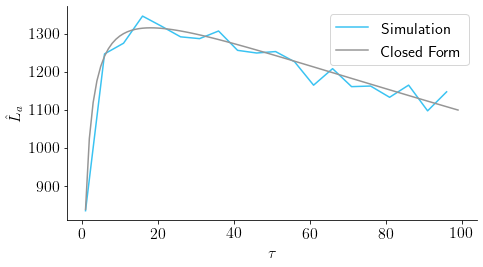

In [43]:
plt.figure(figsize=[7,4])
plt.plot(taus_simulated, L_a_simulated, color=blue, label='Simulation')
plt.plot(taus_closed_form, L_a_closed_form, color=gray, label='Closed Form')
plt.xlabel("$$ \displaystyle \\tau $$")
plt.ylabel('$\hat{L}_a$')
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig(path.join(figures_path, f'time_aggregated_lift_by_tau.png'), dpi=150)

## Power and results on different parameters

In [274]:
def get_significance_rate(var_D, var_X, m, tau, niter):
    var_c = var_of_group_mean_diff(var_X, m*tau)
    Ds = np.sqrt(var_D) * np.random.randn(niter)
    ds = Ds + np.sqrt(var_c) * np.random.randn(niter)
    cutoff = 1.96 * np.sqrt(var_c)
    sigs = (ds > cutoff) | (ds < -cutoff)
    return sigs.mean()

def plot_tau_by_x(x, optimal_taus, xlabel):
    plt.plot(x, optimal_taus, color=blue)
    plt.xlabel(xlabel)
    plt.ylabel('Optimal duration ($\\tau$)')    
    sns.despine()

def plot_sig_rate_by_x(x, sig_rates, xlabel):
    plt.plot(x, sig_rates, color=pink)
    plt.xlabel(xlabel)
    plt.ylabel('Sig. rate, given optimal $\\tau$')
    sns.despine()
    
def plot_tau_and_sig_rate(x, optimal_taus, sig_rates, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=[10,3])
    plt.sca(axes[0])
    plot_tau_by_x(x, optimal_taus, xlabel)
    plt.sca(axes[1])
    plot_sig_rate_by_x(x, sig_rates, xlabel)
    plt.tight_layout()


def simulate_tau_and_sig_rate_rs(var_D, var_X, m):
    annual_rs = np.linspace(.05, 1.25, 40)
    optimal_taus = []
    sig_rates = []
    for i, annual_r in enumerate(annual_rs):
        optimal_tau = find_optimal_tau(var_D, var_X, m, annual_r/365)
        sig_rate = get_significance_rate(var_D, var_X, m, tau=optimal_tau, niter=1000000)
        optimal_taus += [optimal_tau]
        sig_rates += [sig_rate]
    return annual_rs, optimal_taus, sig_rates

def simulate_tau_and_sig_rate_ms(var_D, var_X, r):
    ms = np.linspace(100, 1000, 40)
    optimal_taus = []
    sig_rates = []
    for i, m in enumerate(ms):
        optimal_tau = find_optimal_tau(var_D, var_X, m, r)
        sig_rate = get_significance_rate(var_D, var_X, m, tau=optimal_tau, niter=1000000)
        optimal_taus += [optimal_tau]
        sig_rates += [sig_rate]
    return ms, optimal_taus, sig_rates
    

In [293]:
p = 0.1

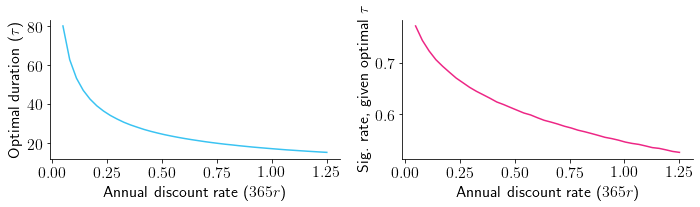

In [296]:
annual_rs, optimal_taus, sig_rates = simulate_tau_and_sig_rate_rs((.01)**2, var_X=p * (1-p), m=1000)
plot_tau_and_sig_rate(x=annual_rs, optimal_taus=optimal_taus, sig_rates=sig_rates, 
                      xlabel='Annual discount rate ($365r$)')
plt.savefig(path.join(figures_path, f'optimal_tau_and_sig_rate_by_r.png'), dpi=150)

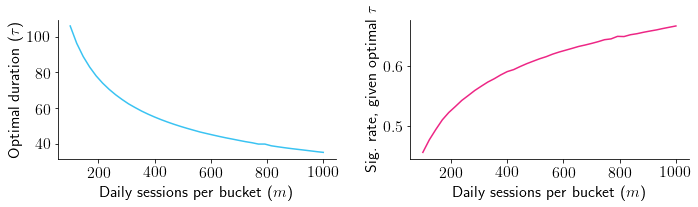

In [302]:
ms, optimal_taus, sig_rates = simulate_tau_and_sig_rate_ms((.01)**2, var_X=p * (1-p), r=0.25/365)
plot_tau_and_sig_rate(x=ms, optimal_taus=optimal_taus, sig_rates=sig_rates, xlabel='Daily sessions per bucket ($m$)')
plt.savefig(path.join(figures_path, f'optimal_tau_and_sig_rate_by_m.png'), dpi=150)
    

### Asymmetric shoulders

In [252]:
def plot_L_a_by_tau(taus, L_as):
    plt.plot(taus, L_as, color=blue)
    sns.despine()

In [309]:
var_D = (0.01)**2
p = 0.1
var_X = p*(1-p)
m = 100
r = 1/365

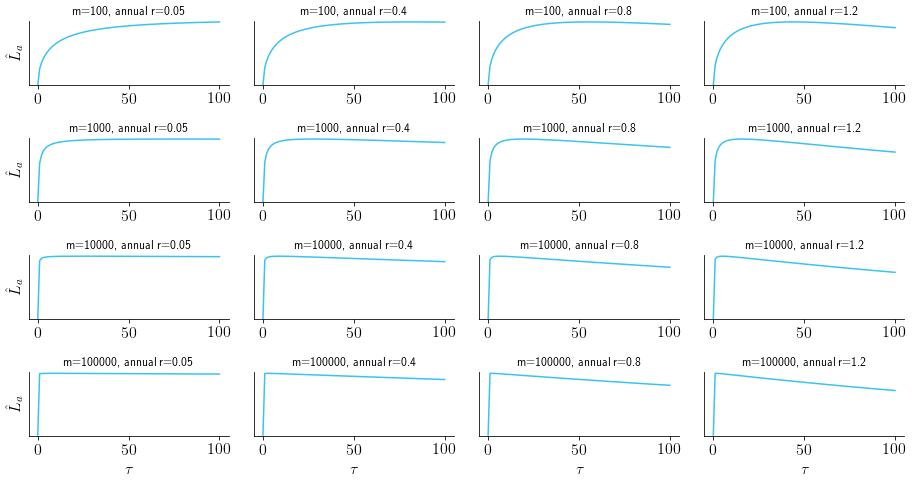

In [314]:
ms = [100, 1000, 10000, 100000]
annual_rs = [0.05, 0.40, 0.80, 1.2]
nrow = len(ms)
ncol = len(annual_rs)
fig, axes = plt.subplots(nrow, ncol, figsize=[13, 7])
for i, m in enumerate(ms):
    for j, annual_r in enumerate(annual_rs):
        r = annual_r/365
        taus = np.linspace(.00001, 100, 100)

        L_as = np.array([get_agg_lift_via_closed_form(var_D=var_D, var_X=var_X, m=m, tau=tau, r=r, M=1)
                for tau in taus])
        plt.sca(axes[i, j])
        plot_L_a_by_tau(taus, L_as)
        plt.ylim([0, 1.02*L_as.max()])

        if i == nrow-1:
            plt.xlabel("$$ \displaystyle \\tau $$")
        if j == 0:
            plt.ylabel('$\hat{L}_a$')
        
        plt.yticks([])
        plt.title('m=' + str(int(m)) + ', annual r=' + str(annual_r), fontsize=12)

plt.tight_layout()
plt.savefig(path.join(figures_path, f'L_a_by_tau_for_m_and_r.png'), dpi=150)


### Time-discounting plots

In [104]:
def get_ts(t, tau, p, var_D, m, r):
    n = m*tau
    L = get_lift_via_closed_form(var_D=var_D, var_X=p*(1-p), n=n)
    per_user_lift_over_time = np.where(t < tau, 0, L)
    discount = discount_function(t, M=1, L=1, r=r)
    discounted_lift = per_user_lift_over_time * discount
    return per_user_lift_over_time, discount, discounted_lift

def plot_ts(t, y, ylabel, color, fill=False, ymax=None):
    plt.plot(t, y, color=color)
    if fill:
        plt.fill_between(t, y, color=color, alpha=.3)
    if ymax:
        plt.ylim(0, ymax)
    plt.ylabel(ylabel)
    sns.despine()


In [105]:
t = np.arange(0, 365*3)
tau = 90
p = 0.1
var_D = .01**2
m = 100
M = 1000
r = 1/365

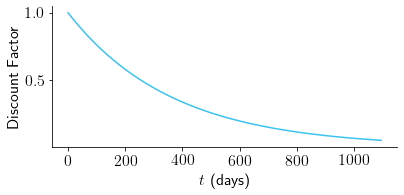

In [106]:
per_user_lift_over_time, discount, discounted_lift = get_ts(t, tau, p, var_D, m, r)
plt.figure(figsize=[6,3])
plot_ts(t, discount, 'Discount Factor', color=blue)
plt.xlabel('$t$ (days)')
plt.tight_layout()
plt.savefig(path.join(figures_path, f'discount_function.png'), dpi=150)

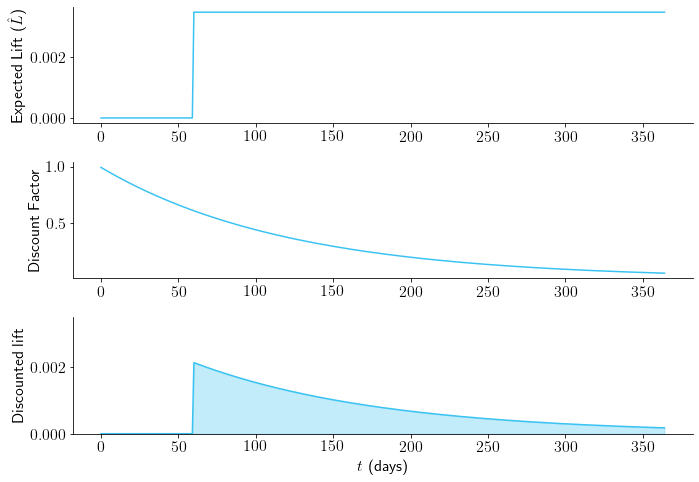

In [112]:
t = np.arange(0, 365)
tau = 60
p = 0.1
var_D = .01**2
m = 100
M = 1000
r = 3/365
per_user_lift_over_time, discount, discounted_lift = get_ts(t, tau, p, var_D, m, r)
    
fig, axes = plt.subplots(3, 1, figsize=[10, 7])
plt.sca(axes[0])
plot_ts(t, per_user_lift_over_time, 'Expected Lift ($\hat{L}$)', color=blue)
plt.sca(axes[1])
plot_ts(t, discount, 'Discount Factor', color=blue)
plt.sca(axes[2])
plot_ts(t, discounted_lift, 'Discounted lift', color=blue, fill=True, ymax=per_user_lift_over_time.max())
plt.xlabel('$t$ (days)')
plt.tight_layout()
plt.savefig(path.join(figures_path, f'discounted_lift_static.png'), dpi=150)

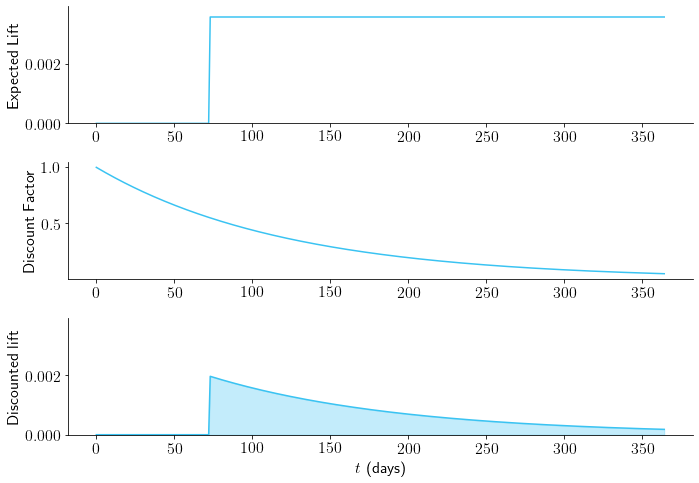

In [622]:
t = np.arange(0, 365)
taus = np.arange(1, 75, 3)
p = 0.1
var_D = .01**2
m = 100
M = 1000
r = 3/365

# Compute max lift, for fixing ylim
per_user_lift_over_time, discount, discounted_lift = get_ts(t, taus[-1], p, var_D, m, r)
max_lift = per_user_lift_over_time.max()
ymax = max_lift * 1.1

fig, axes = plt.subplots(3, 1, figsize=[10, 7])
for i, tau in enumerate(taus):
    [ax.clear() for ax in axes]
    per_user_lift_over_time, discount, discounted_lift = get_ts(t, tau, p, var_D, m, r)

    plt.sca(axes[0])
    plot_ts(t, per_user_lift_over_time, 'Expected Lift', color=blue, ymax=ymax)
    plt.sca(axes[1])
    plot_ts(t, discount, 'Discount Factor', color=blue)
    plt.sca(axes[2])
    plot_ts(t, discounted_lift, 'Discounted lift', color=blue, fill=True, ymax=ymax)
    plt.xlabel('$t$ (days)')
    plt.tight_layout()

    plt.savefig(path.join('frames', f'discounted_lift_dynamic_{i:02d}.png'), dpi=100)
